# Cloning Quasars

Sloan Digital Sky Survey(SDSS) contains milions of quasar data. 

#### Firstly we download the redshift data of the first 10000 quasars

In [1]:
import numpy as np
import scipy.stats
from scipy import stats, interpolate
from matplotlib import pyplot as plt

from astroML.datasets import fetch_dr7_quasar

import astropy
astropy.cosmology.Planck18

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

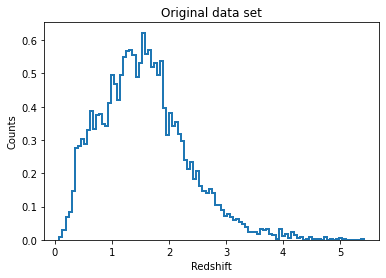

In [2]:
plt.hist(z,bins=100,histtype='step',density=True, linewidth = 2)
plt.title("Original data set")
plt.xlabel("Redshift")
plt.ylabel("Counts")
plt.show()

#### Now we want to upsample our data set using two methods:
* Rejection sampling
* Inverse transform sampling

## Rejection Sampling

We upsample our data set from $10^4$ to $10^6$

In [3]:
#rejection sampling
Ndata = 10000
Nclone = 1000000


In [4]:
counts, bins = np.histogram(z, bins = 100, density= True)
max(counts)

0.6225033764724289

100%|██████████| 1000000/1000000 [00:01<00:00, 889478.34it/s]


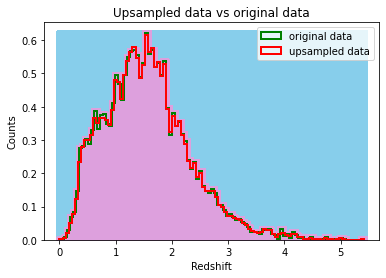

In [20]:
from tqdm import tqdm

ymax = max(counts)
x = np.random.uniform(0,max(z),Nclone)
y = np.random.uniform(0,ymax,Nclone)
inds = np.digitize(x, bins, right=True)

#print(len(inds))
Cont = np.zeros(len(inds))
#print(len(counts))

for i in tqdm(range(len(inds))):
    Cont[i] = counts[inds[i]-1]
    
plt.scatter(x[y>Cont],y[y>Cont],c='skyblue', marker = ',')
plt.scatter(x[y<Cont],y[y<Cont],c='plum', marker = ",")


goodpoints = x[y<Cont]

plt.hist(z,bins=100,histtype='step',density=True, linewidth = 2, label = 'original data', color='green')
plt.hist(goodpoints,bins=100,density=True, linewidth = 2, histtype='step',color='red',  label = 'upsampled data')

plt.legend(loc = 'upper right')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.title('Upsampled data vs original data')
plt.show()


## Inverse transform sampling

We upsample our data set from $10^4$ to $10^6$

#### Let's compute first the cdf $H(x)$

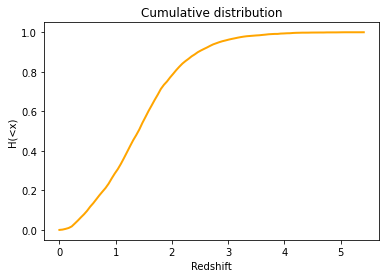

In [6]:
cdf = np.cumsum(counts) / np.sum(counts)

plt.plot(np.linspace(0,max(z),100),cdf, linewidth = 2, color='orange')
plt.xlabel('Redshift')
plt.ylabel('H(<x)')
plt.title('Cumulative distribution')
plt.show()


#### And now the inverse $H^-1(x)$

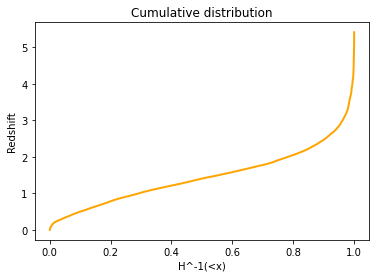

In [7]:
plt.plot(cdf,np.linspace(0,max(z),100), linewidth = 2, color='orange')
plt.ylabel('Redshift')
plt.xlabel('H^-1(<x)')
plt.title('Cumulative distribution')
plt.show()

(Same thing but using stats methods)

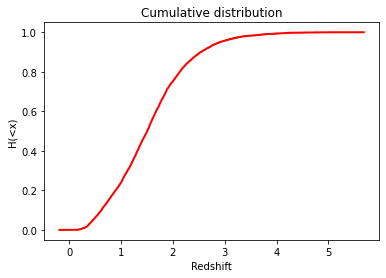

In [8]:
res = stats.ecdf(z)
ax = plt.subplot()
res.cdf.plot(ax, linewidth = 2, color='red')
ax.set_xlabel('Redshift')
ax.set_ylabel('H(<x)')
ax.set_title('Cumulative distribution')
plt.show()

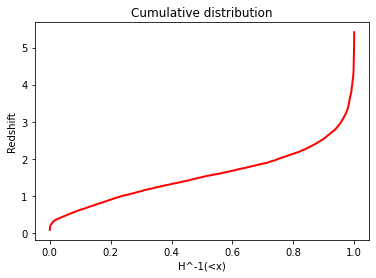

In [9]:
plt.plot(res.cdf.probabilities, res.cdf.quantiles, linewidth = 2, color='red')
plt.ylabel('Redshift')
plt.xlabel('H^-1(<x)')
plt.title('Cumulative distribution')
plt.show()

#### Now we set up an interpolation of the inverse cumulative distribution

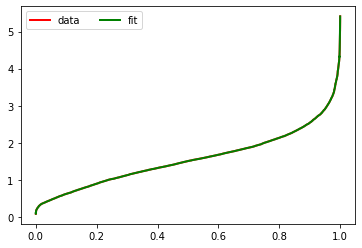

In [10]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(res.cdf.probabilities, res.cdf.quantiles)
plt.plot(res.cdf.probabilities, res.cdf.quantiles, label="data",color='red', linewidth = 2)
xs = np.arange(0.0, 1, 0.000001)
plt.plot(xs, cs(xs), label="fit",color='green', linewidth = 2)
plt.legend(loc='upper left', ncol=2)

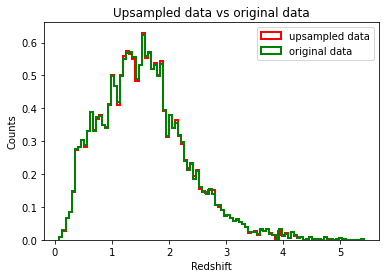

In [11]:
x_up = np.random.uniform(0,1,Nclone)
upsample = cs(x_up)
plt.hist(upsample, density=True, bins=100,linewidth = 2, histtype='step',color='red',  label = 'upsampled data')
plt.hist(z,bins=100,density=True,linewidth = 2,histtype='step', label = 'original data', color='green')
plt.legend(loc = 'upper right')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.title('Upsampled data vs original data')
plt.show()


# Theoretical distribution of quasars in function of redshift

Let's try to assume that quasars are distributed uniformly in comoving volume in the Universe. 

We use the cosmological parameters as measured by the Plack satellite, which is a flat CDM model

In [12]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [13]:
class uniformredshift(object):
    def __init__(self,zmax):
        ''' Lazy loading...'''
        self._norm = None
        self._pdfmax = None
        self.zmax=zmax

    def _eval(self,z_vals):
        '''Unnormalized pdf'''
        return ((4.*np.pi*astropy.cosmology.Planck18.differential_comoving_volume(z_vals).value))


    def norm(self):
        '''Compute normalization'''
        if self._norm is None:
            self._norm = scipy.integrate.quad( self._eval, 0, self.zmax)[0] #to compute a definite integral
        return self._norm


    def eval(self,z_vals):
        return self._eval(z_vals)/self.norm()

        return np.array(zsample)

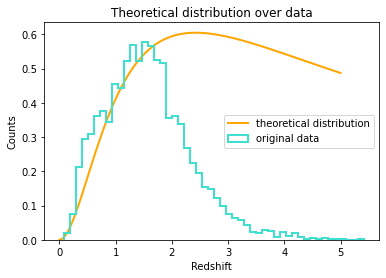

In [14]:
redshiftpdf = uniformredshift(zmax = 5)

x = np.linspace(0,5,100)
plt.plot(x,2.4*redshiftpdf.eval(x), label='theoretical distribution', linewidth=2, color='orange') ###   Arbitrary normalization, just matching by eye

plt.hist(z,bins=50,histtype='step',density=True,label='original data', color='turquoise', linewidth=2)
plt.legend(loc = 'center right')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.title('Theoretical distribution over data')
plt.show()

Quasars are distrubuted uniformerly in comuving volume only at low redshift.